<h1>Tower Battery Documentation</h1>

<h2>Load Calculation</h2>
Current of the whole tower system was measured using a current clamp attached to a programmable dc power supply. The current was logged in current_average_operation.csv and current_startup.csv. The power consumption of the upcore is modeled as the average power consumption of when the upcore first turns on for 1 minute, the average power consumption of when the upcore is running its tracking program (set to 2 minutes by default), and then 0 Watts for however long the upcore is kept off for per cycle (27 minutes with default values). Additionally, if any peripherals are added that must always be turn on are added, the power consumption of these can be added as constant (see load_constant variable).

<h2>System Model</h2>
The power system consists of 2 solar panels in series connected to a mppt charge controller, which is connected to both a deep cycle lead acid battery and the tower electronics. During the day, the solar panel will supply power and charge the lead acid battery, while the battery will supply power during the night. The simulation works by averaging the power outputted over a time interval based off of the solar radiation data, multiplying the power by the time interval length to get energy generated/used over this period, and then summing the energy. It also factors into account losses from temperature, the solar panel charge controller, and the lead acid battery charging efficiency. <br />
<h4> Solar Panels </h4>
The reason why 2 solar panels in series was chosen was because the charge controller can only manage charging the battery when the voltage is above a certain threshold, which varies by charge controller, but can be between 9-14V. If the panel is outputting a lower voltage, then the charge controller is unable to charge the battery. By putting 2 panels in series, the output voltage is higher, meaning the batteries are charging more often. Additionally, a single 100W solar panel does not supply enough power for most locations, so 2 100W panels or a 200W panel would be needed regardless. <br />
For the simulation, the solar panels were modelled using the equation: $$ P_{output} = Solar Radiation * Area * Panel Efficiency * (1 -|T_{optimal}- T_{actual}| * T_{coeff})$$
Equation was derived from kWh output of panel = Wattage of sun * Hours of sunlight * panel efficiency<sup>1</sup>. By dividing by hours, the equation becomes Wattage from panel = Wattage of sun * panel efficiency. Additionally, the temperature of the panels can further affect the performance of the panel, as each degree above/below 77 F will result in reduced power output<sup>2</sup>.
*Units of Radiation is W/m^2, area is m^2, temperature is in F, and Temperature coefficient is 1/F <br />
Additionally, the maximum output of the panel can be included, as panels cannot output more than this rating. In the simulation, if the panel is outputting more than the maximum, it will be automatically set to this value. 
<h4>Charge Controllers</h4>
Charge controllers are necessary for solar panel systems, as they will ensure that the battery will not be damaged while charging. There are 2 types, which are PWM and MPPT controllers. PWM controllers are much less efficient, as around 25% of the energy from the panel is lost while charging (as opposed to 5% for MPPT), but are also aroudn 40-50\$ cheaper for each controller. However, this extra 20% of efficiency lost would mean that another solar panel would be needed to supply enough power, which would cost an extra 100\$, meaning the cost benefits would not be worth it, which is why a MPPT controller was chosen. <br />
In the simulation, the charge controller affects the input power in 2 ways, through its efficiency and its minimum input voltage. The efficiency is a straightforward multiplier to how much power is entering the system. The minimum input voltage is derived from the power of the solar panel. You can reference the solar panel data sheet and look for the curve characteristics chart. Using this chart, you can find the voltage at which the charge controller no longer works correctly, and find the power output at this voltage. Then, during the simulation, any panel output value which is below this threshold can be thrown out, to simulate how the charge controller would not work due to low voltage.
<h4>Lead Acid Battery</h4>
The type of battery needed is a 12V deep cycle lead acid battery. The main reason this battery was chosen was its cost, as lead acid batteries are the cheapest high capacity batteries (when compared to lithium for example). Something important to note is that the lead acid batteries will be potentially discharged to 100%, which would damage the battery. This is not an issue for a few reasons. First, when using a depth-of-discharge (DOD) of 100% consistently, the battery life drops from 500 cycles to 200 cycles, however, 200 cycles (or around 200 days) is plenty of time for the system to be deployed multiple times. Additionally, the battery is sized for the least sunny period, which means that it will reach a DOD close to 100% during this time, but will usually have a lower DOD. This means that the battery will not take as much damage, meaning that the 200 cycles is a lower bounds estimate. <br />
The battery uses a charge efficiency of 80% by default, which is standard for a lead acid battery. The battery also can only store about Amp-hour Rating * (12.6-10.8)/2 watt-hours of energy. The (12.6-10.8)/2 is used to represent the average voltage of the battery, which gives an approximate total energy that can be stored in the battery.
<h5>links for placeholder components</h5> 

 - solar panel: https://richsolar.com/products/100-watt-solar-panel
 - charge controller: https://richsolar.com/products/20-amp-mppt-solar-charge-controller

<h2>References</h2>

1. Punjabi, S. (2023, October 31). Calculating Daily Power Production for Each kW of Solar Panels. Fenice Energy. https://feniceenergy.com/calculating-daily-power-production-for-each-kw-of-solar-panels/ 
2. Maysun Solar. (2023, November 10). Temperature Coefficient and Solar Panels：2023 Guide. Linkedin. https://www.linkedin.com/pulse/temperature-coefficient-solar-panels2023-guide-maysun-solar-china-hprqe/ 

<H2>How to Use</H2>
Create a json file to contain column mappings, the number of panels, the location of the data csv file and the number of points per day. Next, update the setup_file_path variable to be the path to this .json file.

In [1]:
import extraneous_functions as func
from pathlib import Path
setup_file_path = Path("./setup_ca_su23.json")
date_col, temp_col, sunl_col, number_of_panels, file_name, num_points_per_day = func.setup_csv(setup_file_path)
number_of_panels = 2


#ensure all packages are install on jupyter kernel
try:
    import numpy
except ImportError:
   	!pip install numpy
try:
   	import matplotlib
except ImportError:
   	!pip install matplotlib


<H2>Component Values</H2>
Update each component values below to match the components you plan on using. All of the solar panel and charge controller values can be found in the datasheets. The lead acid battery values are standard for generally all lead acid batteries. System losses and the fail threshold can be modified as well to test the system more rigorously.

In [2]:
# ------------component values, see datasheets for each component to determine------------
# solar panel
optimal_temp = 77 # measured in F
temp_coeff = 0.39 # measured in %/F
area = 0.535934412 # measured in m^2
panel_efficiency = 0.198 
panel_max_output = 100 # measured in watts

# charge controller
charge_controller_efficiency = 0.95 
minimum_charging_power = 5 # measured in watts

# battery
battery_efficiency = 0.8 # standard for lead acid batteries, shouldn't be changed
avg_voltage = (12.6 + 10.8) / 2 # average voltage of a 12V lead acid battery

# load
load_constant = 0.75 # any peripherals that are always kept on, measured in amps consumed at 12 V
load_current_startup = func.get_average_startup_current() # average power consumed during startup
load_current_operation = func.get_average_expected_behavior() # average power consumed while running program
load_voltage = 12
cycle_time = 30 / 60 # cycle time in hours
time_to_measure = 120 / (60 * 60) # measured in hours
startup_time = 60 / (60 * 60)
time_on = time_to_measure + 60 / (60 * 60) # measured in hours
time_off = (cycle_time - time_on) / 60 # measured in hours

# example numbers above assume that the tower will get location data twice/hours and takes 2 minutes to run program

# system
system_losses = 0.1
fail_threshould = 0.4 # % charge of battery where system could fail

#variable setup - do not edit
time_arr = [0] # array of dates
time_arr_day = [0] # number of days from start of simulation
percent_capacity = [0.0] # % capacity of the battery
wh_capacity = [0] # Watt-hour capacity of the battery
w_sunlight = [0] # solar radiation
wh_sunlight = [0] # energy hitting solar panels over period of time
wh_battery_charging_input = [0] # charge controller output power
data_file_path = Path("./" + file_name)
start_time = "none"
end_time = "none"


<h2>Simulation</h2>
As was explained above,the simulation will be repeatedly done for various battery sizes to determine the minimum sized battery that will work. The simulation works by estimating the integral of the function of power output with respect to time, which equates to energy generated. It will also factor power used by the load and model the charge controller.

In [3]:
# function to 
def handle_simulation(battery_size):
    import csv
    from datetime import datetime
    battery_capacity = battery_size # measured in AH
    max_capacity = battery_capacity * avg_voltage # measured in WH
    date_arr = []
    temp_arr = []
    sunl_arr = []
    time_diff_arr = []
    coeff_arr = []
    charge_ctrler_output_arr = []
    power_consumed_arr = []
    global time_arr 
    time_arr = [0.0]
    global percent_capacity 
    percent_capacity = [1]
    global wh_capacity
    wh_capacity = [avg_voltage * battery_size]

    startup_time_left = startup_time
    program_time_left = 0
    time_off_left = 0
    next_state = 0 # 0 is startup, 1 is measuring, 2 is off

    #set first value to be 0, to make indexing match
    global w_sunlight
    w_sunlight = [0]
    global wh_sunlight
    wh_sunlight = [0]
    global wh_battery_charging_input
    wh_battery_charging_input = [0]
    global time_arr_day
    
    # read data and insert into arrays
    with open(data_file_path, mode = 'r', encoding='utf-8') as file:
        csvFile = csv.reader(file)
        count = 0
        for line in csvFile:
            date_arr.insert(0, line[date_col])
            temp_arr.insert(0, line[temp_col])
            sunl_arr.insert(0, line[sunl_col])
            

    date_arr.pop()
    temp_arr.pop()
    sunl_arr.pop()

    global start_time
    start_time = date_arr[0]
    global end_time
    end_time = date_arr[-1]

    # convert data values from strings to floats after header removed
    for idx in range(len(date_arr)):
        temp_arr[idx] = float(temp_arr[idx])
        sunl_arr[idx] = float(sunl_arr[idx])

    # calculate time difference between each data point and store
    for idx in range(len(date_arr) - 1): 
        initial_time = datetime.strptime(date_arr[idx], '%Y-%m-%d %H:%M:%S')
        final_time = datetime.strptime(date_arr[idx+1], '%Y-%m-%d %H:%M:%S')
        difference = final_time - initial_time
        d_h = (difference.total_seconds() / 3600.0)
        
        time_diff_arr.append(d_h)

    # calculate temperature adjust coefficient
    for idx in range(len(temp_arr)):
        coeff_arr.append(1 - abs(temp_arr[idx] - optimal_temp) * temp_coeff / 100)


    # calculate power outputted by solar panels
    for idx in range(len(temp_arr)):
        output = sunl_arr[idx] * area * panel_efficiency * coeff_arr[idx]
        
        # model maximum output of solar panel
        if output > panel_max_output:
            output = panel_max_output
        output = output * number_of_panels

        # model charge controller 
        if output < minimum_charging_power:
            output = 0
        if (output / 12) > 20:
            output = 12 * 20
        output = output * charge_controller_efficiency
        charge_ctrler_output_arr.append(output)

        # estimate solar radiation seen over this period
        if idx > 0:
            w_sunlight.append((sunl_arr[idx] * area + sunl_arr[idx-1] * area) / 2 * number_of_panels)

    # generate time values in hours
    for idx in range(len(time_diff_arr)):
        time_arr.append(time_arr[idx] + time_diff_arr[idx])
        time_arr_day.append((time_arr[idx] + time_diff_arr[idx]) / 24);

    if_system_fails = False

    max_pow = 0
    # calculate how much power is consumed by the system each interval
    for idx in range(len(time_diff_arr)):
        power_consumed_arr.append(0)
        num_cycles_completed = time_diff_arr[idx] / cycle_time
        leftover_time = time_diff_arr[idx] % cycle_time

        
        # calculate the power consumed for an incomplete cycle, based off where the previous time interval left off
        if leftover_time > 0:
            # at the end of the previous interval, the tower hadn't finished starting up
            if next_state == 0:
                # by the end of the current interval, the tower will be starting up
                if leftover_time < startup_time_left: 
                    startup_time_left = startup_time_left - leftover_time
                    power_consumed_arr[idx] = leftover_time * load_current_startup
                    next_state = 0
    
                # by the end of the current interval, the tower will be running the program
                elif leftover_time < (startup_time_left + time_to_measure): #
                    startup_time_left = 0;
                    program_time_left = time_to_measure - (leftover_time - startup_time_left)
                    power_consumed_arr[idx] = startup_time_left * load_current_startup + (leftover_time - startup_time_left) * load_current_operation
                    next_state = 1
    
                # by the end of the current interval, the tower will be waiting to turn back on
                else:
                    time_diff_arr[idx] = 0;
                    time_off_left = time_off - (leftover_time - time_to_measure - startup_time_left)
                    power_consumed_arr[idx] = startup_time_left * load_current_startup + time_to_measure * load_current_operation
                    next_state = 2
    
            # at the end of the previous interval, the tower hadn't finished running the program
            elif next_state == 1:
                # by the end of the current interval, the tower will be running the program
                if leftover_time < program_time_left:
                    program_time_left = program_time_left - leftover_time
                    power_consumed_arr[idx] = leftover_time * load_current_operation
                    next_state = 1
    
                # by the end of the current interval, the tower will be waiting to turn back on
                elif leftover_time < (program_time_left + time_off):
                    program_time_left = 0
                    time_off_left = time_off - (leftover_time - program_time_left)
                    power_consumed_arr[idx] = program_time_left * load_current_operation
                    next_state = 2
    
                # by the end of the current interval, the tower will be starting up
                else:
                    program_time_left = 0
                    startup_time_left = startup_time - (leftover_time - time_off - program_time_left)
                    power_consumed_arr[idx] = program_time_left * load_current_operation + (leftover_time - time_off - program_time_left) * load_current_startup
                    next_state = 0
    
            # at the end of the previous interval, the tower hadn't finished waiting to turn back on
            else:
                # by the end of the current interval, the tower will be waiting to turn back on
                if leftover_time < time_off_left:
                    time_off_left = time_off_left - leftover_time
                    power_consumed_arr[idx] = 0
                    next_state = 2
    
                # by the end of the current interval, the tower will be starting up
                elif leftover_time < (time_off_left + startup_time):
                    time_off_left = 0
                    startup_time_left = startup_time - (leftover_time - time_off_left)
                    power_consumed_arr[idx] = (leftover_time - time_off_left) * load_current_startup
                    next_state = 0
    
                # by the end of the current interval, the tower will be running the program
                else:
                    time_off_left = 0
                    program_time_left = time_to_measure - (leftover_time - startup_time - time_off_left)
                    power_consumed_arr[idx] = startup_time * load_current_startup + (leftover_time - startup_time - time_off_left) * load_current_operation
                    next_state = 1
        else:
            power_consumed_arr[idx] = 0

        
        #calculate power consumed for all completed cycles
        power_consumed_arr[idx] = power_consumed_arr[idx] + (load_current_startup * startup_time + load_current_operation * time_to_measure) * load_voltage * num_cycles_completed + load_constant * time_diff_arr[idx]
        
    # calculate voltage of 
    for idx in range(len(time_diff_arr)):
        #w_sunlight.append((charge_ctrler_output_arr[idx] + charge_ctrler_output_arr[idx+ 1]) / 2 * battery_efficiency * time_diff_arr[idx-1])
        next_incr = wh_capacity[idx] - power_consumed_arr[idx] + charge_ctrler_output_arr[idx] * battery_efficiency * time_diff_arr[idx]
        if next_incr > max_capacity:
            next_incr = max_capacity
        elif next_incr < 0:
            next_incr = 0
        wh_capacity.append(next_incr)
        percent_capacity.append(next_incr * 1.0 / max_capacity)

        if percent_capacity[-1] <= fail_threshould:
            if_system_fails = True

    return if_system_fails

<h2>Sweep and Plotting</h2>
By default, the simulation will sweep up to a battery of 200 AH in increments of 10. If you would like to change this, then you can change the increment size (incr_size) or the number of increments (num_incrs).

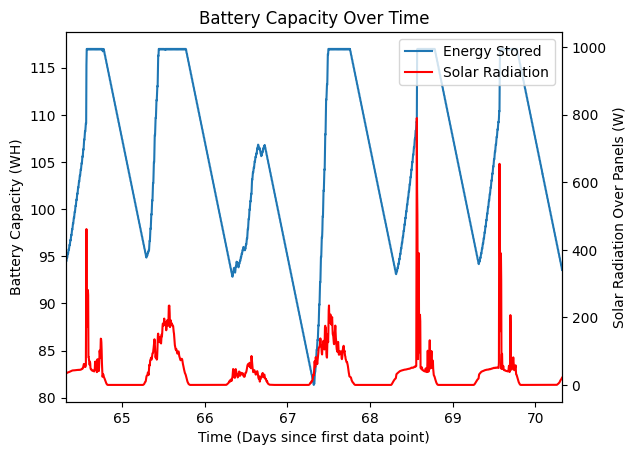

From 2023-06-15 00:00:00 to 2023-09-15 23:55:00: 
system provides enough power with 2 panels
A 10 AH battery is recommended


In [4]:
incr_size = 10
num_incrs = 20
if_success = False
smallest_cap = 0
for idx in range(num_incrs):
    if idx > 0:
        if_fails = handle_simulation(idx*incr_size)
        if not if_fails:
            global smallest_cap
            smallest_cap = idx * incr_size
            func.plot_data(time_arr, wh_capacity, w_sunlight, num_points_per_day)
            if_success = True
            break

print("From " + start_time + " to " + end_time + ": ")
if if_success:
    print("system provides enough power with " + str(number_of_panels) + " panels")
    print("A " + str(smallest_cap) + " AH battery is recommended")
else:
    print("system does not provide enough power")
    func.plot_data(time_arr, wh_capacity, w_sunlight, num_points_per_day)


Above is where the final output is displayed. The plot shows the point where the system either fails, or gets as close to failing as possible. The solar radiation is also displayed, to help show why the system failed. If it fails for the entire sweep, then consider increasing the number of solar panels. Generally, a larger battery will improve performance when there is an occasional string of cloudy days, while increasing the number of panels will improve performance if there is regularly not enough power generated.